In [1]:
import os
import sys

import re
import time
import pickle

import pandas as pd
import numpy as np
from IPython.display import Image, display
import glob

from gensim import corpora, models, similarities
from gensim.test.utils import get_tmpfile
from nltk.corpus import stopwords

In [2]:
# define a working directory where the data is located. Also a place to store files 
work_dir = '/media/hdd1/bsong/image_text'

# pull captions
captions_raw = []
with open(work_dir + '/results_20130124.token','r') as cap_text:
    for line in cap_text:
        captions_raw.append(line)

# create a directory inside the working directory to cleanly store files
if not os.path.exists(work_dir + '/model_files'):
    os.makedirs(work_dir + '/model_files')

In [3]:
class my_timer:
    '''
    Simple timer class to capture time it takes to run chunks of code and print out message.
    '''
    def __init__(self):
        self.start_time = time.time()
        self.reset_time = time.time()

    def print_reset(self, some_str):
        # some_str to printout note: 'time to (some_str)' i.e. "time to run some_function()"

        tot_time = time.time() - self.reset_time

        m, s = divmod(tot_time, 60)
        h, m = divmod(m, 60)
        h, m, s = map(int, (h, m, s))
        print('time to ' + some_str + ': ' + str(h) + ' hour(s) ' + str(m) + ' minute(s) ' + str(s) + ' second(s).')	


        self.reset_time = time.time()

    def time_from_init(self):
        # get the total time from when this class was initiated 

        tot_time = time.time() - self.start_time

        m, s = divmod(tot_time, 60)
        h, m = divmod(m, 60)
        h, m, s = map(int, (h, m, s))
        print('total time since starting time: ' + str(h) + ' hour(s) ' + str(m) + ' minute(s) ' + str(s) + ' second(s).')

def preprocess_text(text):
    '''
    Simple (fast) text preprocessing. 
    1. Split text like 'cleaning/detailing' into 'cleaning detailing'
    2. remove special characters (only alphanumeric string should remain)
    3. Lowercase all the words
    
    This is preprocessing text sentences at a time. Slower, but potentially 
    stronger, text preprocessing methods (lemmatizing, stemming, etc.) can be 
    done through nltk or other packages. The slowness of these preprocessing methods
    arises from the fact that those are done one token at a time, so plan accordingly. 
    '''
    def remove_special_char(text):
        special_char = ['.',',','=','-','_','?','!',';',':',"'",'"','(',')','*','&','^','%','$','#','@','~','`','+','/','\\'] #,'?','!',';',':',"'",'"' temporarily added
        for i in special_char:
            text = text.replace(i,'')
        return text
    text = re.sub('/',' ', text) # sometimes people write like 'cleaning/detailing', so replace / with space
    text = remove_special_char(text)
    text = text.lower()
      
    return text

def chunks(l, n):
    """
    Yield successive n-sized chunks from l.

    The way it is used here is splits a sequence of indices to multiple sequences
    chunks(range(12), 3) will return
    [[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]

def group_string(list_strings):
    '''
    Group a list of strings to one
    '''
    return ' '.join(list_strings)

def f7(seq):
    '''
    reduce a list to unique values only. set() loses order, so extra steps are taken to 
    prevent sorting.
    '''
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def f7_tup(seq):
    '''
    modified f7() to work with tuples specific to this script
    '''
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x[0] in seen or seen_add(x[0]))]

def string_as_gen(tup, type_, dict_ = dict(), tfidf = dict(), lsi = dict()):
    '''
    Store all the string as a generator with string split by space.
    
    Generators help keep the memory usage low (which increases unnecessarily when having a list of lists)
    '''
    if type_ == 'dict':
        for i in tup:
            yield i[1].split()
    elif type_ == 'tfidf':
        for i in tup:
            yield dict_.doc2bow(i[1].split())
    elif type_ == 'lsi':
        for i in tup:
            yield tfidf[dict_.doc2bow(i[1].split())]
    elif type_ == 'full':
        for i in tup:
            yield lsi[tfidf[dict_.doc2bow(i[1].split())]]
            
class similarity:
    '''
    Wrapper class to keep writing clean. 
    '''
    def __init__(self, dict_, tfidf, lsi, cos_index, ind2img, tuple_pic_cap, preprocess_text):
        self.dict_ = dict_
        self.tfidf = tfidf
        self.lsi = lsi        
        self.cos_index = cos_index
        self.ind2img = ind2img
        self.tuple_pic_cap = tuple_pic_cap
        self.preprocess_text = preprocess_text
        
    def get_simil(self, test_string):
        '''
        convert string to lsi representation and find correlating text
        '''
        test_string = self.preprocess_text(test_string).split()
        conv_str = self.lsi[self.tfidf[self.dict_.doc2bow(test_string)]]
        sims = self.cos_index.__getitem__(conv_str)
        if sims == []:
            print('no matches found')
            return None
        else:
            captions = map(lambda x: tuple_pic_cap[x[0]][1], sims)
            sims = map(lambda x: tuple([self.ind2img[x[0]], x[1]]), sims)
            sims = f7_tup(sims)
            return sims, captions
            
def print_results(test_string, dummy, df, n = 5):
    '''
    Print out the results of the model given a test string. May put this in the similarity class.
    '''
    results, captions = dummy.get_simil(test_string)

    for i in range(n):
        one_result = results[i]
        jpgname = one_result[0]
        sim_score = one_result[1]
        caption = df[df.img == jpgname].caption.values
        caption = '\n'.join(caption)
        print('IMAGE #' + str(i))
        display(Image(filename=work_dir + '/flickr30k_images/' + jpgname)) 
        print('picture caption: \n' + str(caption))
        #print('similarity score: ' + str(sim_score))
        print(' ')

In [4]:
## prepare the caption data to feed to the model

timer = my_timer()

# Remove '\n'
captions_raw = map(lambda x: x.replace('\n',''), captions_raw)
print('IMAGE AND CAPTION \n')
print('\n'.join(captions_raw[:5]))

# Remove '#n' from the jpg name and preprocess text. Then create tuples

tuple_pic_cap = map(lambda x: x.split('\t'), captions_raw)
tuple_pic_cap = map(lambda x: tuple([x[0].split('#')[0], preprocess_text(x[1])]), tuple_pic_cap)
print('\nEACH ROW AS TUPLE \n')
print('\n'.join(map(lambda x: '{}'.format(x), tuple_pic_cap[:5])))

# make dataframe to easily join caption text per jpg, then combine text per jpg

df = pd.DataFrame(tuple_pic_cap, columns=['img','caption'])
list_img = f7(list(df.img.values))

df_grouped = df.pivot_table(index = 'img', values = 'caption', aggfunc=group_string)
tuple_pic_cap = tuple(zip(df_grouped.index.values, df_grouped.caption.values))


print('\nFULLY PREPROCESSED TUPLES \n')
print('\n'.join(map(lambda x: '{}'.format(x), tuple_pic_cap[:5])))


timer.print_reset('preprocess captions')

IMAGE AND CAPTION 

1000092795.jpg#0	Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg#1	Two young , White males are outside near many bushes .
1000092795.jpg#2	Two men in green shirts are standing in a yard .
1000092795.jpg#3	A man in a blue shirt standing in a garden .
1000092795.jpg#4	Two friends enjoy time spent together .

EACH ROW AS TUPLE 

('1000092795.jpg', 'two young guys with shaggy hair look at their hands while hanging out in the yard ')
('1000092795.jpg', 'two young  white males are outside near many bushes ')
('1000092795.jpg', 'two men in green shirts are standing in a yard ')
('1000092795.jpg', 'a man in a blue shirt standing in a garden ')
('1000092795.jpg', 'two friends enjoy time spent together ')

FULLY PREPROCESSED TUPLES 

('1000092795.jpg', 'two young guys with shaggy hair look at their hands while hanging out in the yard  two young  white males are outside near many bushes  two men in green shirts are standing in

In [5]:
# make a dictionary to map cosine similarity matrix row index to the associated jpg file name

ind2img = dict(zip(range(len(tuple_pic_cap)), map(lambda(x): x[0], tuple_pic_cap)))

In [6]:
## build gensim dictionary

len_list = len(tuple_pic_cap)
text_for_dict = string_as_gen(tuple_pic_cap, 'dict')
dictionary_ = corpora.Dictionary()
for _ in range(len_list):
    dictionary_.add_documents([text_for_dict.next()])

dictionary_.filter_extremes(no_below = 4, no_above = .9, keep_n = 1000000)

## filter stop words

stopword_set = set(stopwords.words('english'))
stopword_set = map(preprocess_text, stopword_set)
dictionary_.filter_tokens(bad_ids = stopword_set)

timer.print_reset('build dictionary')

time to build dictionary: 0 hour(s) 0 minute(s) 1 second(s).


In [7]:
## build tfidf model

text_for_tfidf = string_as_gen(tuple_pic_cap ,'tfidf', dictionary_)
tfidf = models.TfidfModel(text_for_tfidf)

timer.print_reset('build tfidf model')

time to build tfidf model: 0 hour(s) 0 minute(s) 1 second(s).


In [8]:
## build lsi model
n_topics = 150
text_for_lsi = string_as_gen(tuple_pic_cap, 'lsi', dictionary_, tfidf)
lsi = models.LsiModel(text_for_lsi, id2word = dictionary_, num_topics = n_topics)

timer.print_reset('build lsi model')
## build cosine similarity matrix
text_for_cos = string_as_gen(tuple_pic_cap, 'full', dictionary_, tfidf, lsi)
temp_file = get_tmpfile(work_dir + '/model_files/shard')
cos_index = similarities.Similarity(temp_file, text_for_cos, num_features = n_topics, num_best = 100, shardsize=48000)

timer.print_reset('build cosine similarity matrix')

time to build lsi model: 0 hour(s) 0 minute(s) 7 second(s).
time to build cosine similarity matrix: 0 hour(s) 0 minute(s) 11 second(s).


In [9]:
## save somewhere
dictionary_.save(work_dir + '/model_files/gensim_dict.dict')
pickle.dump(tfidf, open(work_dir + '/model_files/tfidf.pkl','wb'))
pickle.dump(lsi, open(work_dir + '/model_files/lsi.pkl','wb'))
cos_index.save(work_dir + '/model_files/cos_index.pkl')
timer.print_reset('save files')

time to save files: 0 hour(s) 0 minute(s) 0 second(s).


In [10]:
## Use wrapper class to cleanly output things

dummy = similarity(dictionary_, tfidf, lsi, cos_index, ind2img, tuple_pic_cap, preprocess_text)
timer.print_reset('build wrapper')
timer.time_from_init()

time to build wrapper: 0 hour(s) 0 minute(s) 0 second(s).
total time since starting time: 0 hour(s) 0 minute(s) 23 second(s).


IMAGE #0


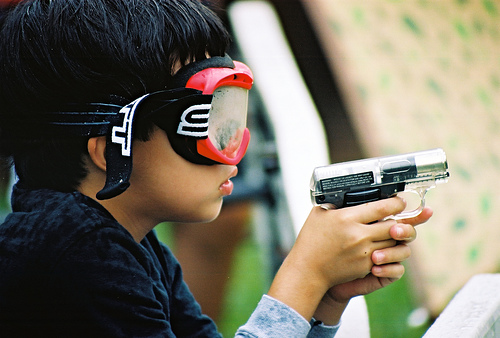

picture caption: 
a child wearing protective goggles fires a small gun 
child wearing glasses learning to shoot a gun 
a little boy wearing goggles is holding a gun 
a little boy in goggles aims a plastic gun 
a child with a toy gun and goggles 
 
IMAGE #1


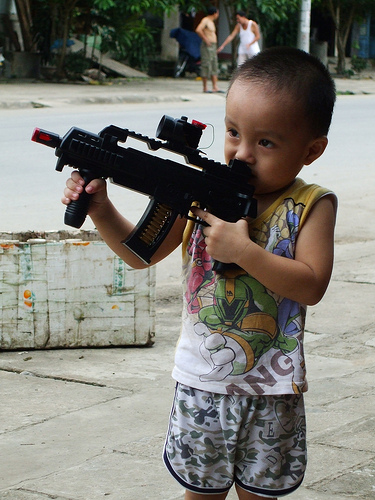

picture caption: 
a young child with a cartoon character on his shirt is holding a toy gun with gold bullets and a handle in the front 
getting familiar with his trade as a filipino child arms maker 
a child  outside  holding a fake weapon 
a little boy is playing with a toy gun 
a small boy playing with a gun 
 
IMAGE #2


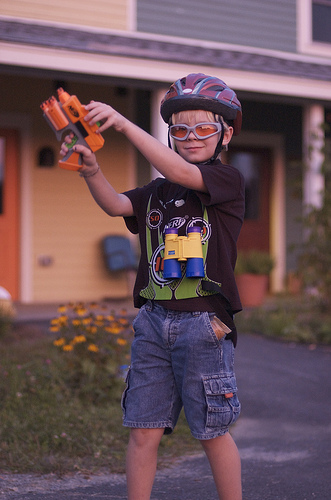

picture caption: 
a young boy  wearing a helmet  in shorts and a tshirt and a pair of binoculars around his neck is playing outside 
a blond child wearing a helmet  goggles and binocular holds up his toy gun 
a little boy who wears a helmet and a sunglasses plays with a toy gun 
a child with play gear is adventuring outside his house 
a blondhaired boy outside playing with a toy gun 
 
IMAGE #3


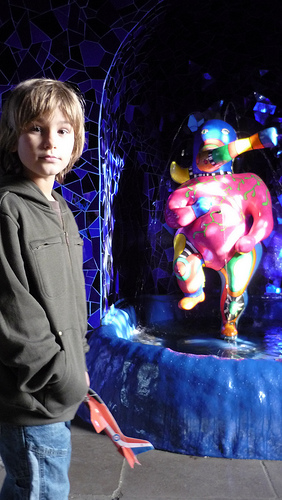

picture caption: 
a blondhair boy holding a toy airplane is in front of what looks like a colorful toy monster 
boy wearing a gray sweatshirt playing with a toy airplane 
a child near a blue stage with a colorful creature on it 
a boy standing in front of a multicolored statue 
a child admires an exhibit or store window 
 
IMAGE #4


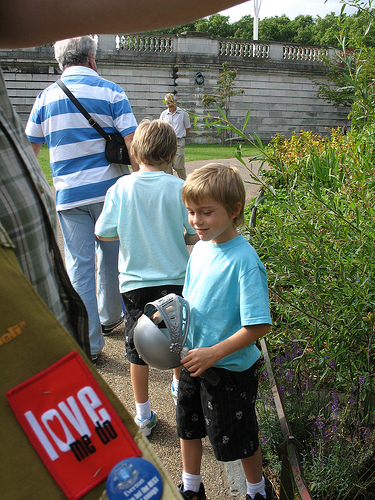

picture caption: 
a boy in a blue shirt holds a toy helmet in his hands while standing on a path in a park 
a young boy holding a toy helmet is about to have some fun 
a boy holding a silver helmet is staring at something 
a young blond boy with a helmet 
a man and two kids are walking
 


In [11]:
## testing block to play with

test_string = 'kid with a gun'

print_results(test_string, dummy = dummy, df = df)